# Sentiment Analysis

### ECE590 Homework assignment 2
Name: Javier Cervantes

net id: jc1010

We are interested in sentiment analysis. Given a short document, we wish to assess whether the corresponding sentiment is positive (label 𝑦=1 ) or negative (label 𝑦=0). The assignment is as follows: 

1. For every word, we will learn a corresponding d-dimensional vector $x_i \in \mathbb{R}^d$ for word $i$ in the vocabulary. 

2. Assume that there are $M_j$ words in document $j$. The feature vector for this document is $f_j = \frac{1}{M_j} \sum_{i=1}^{M_j} x_{(m, j)}$ such that $x_{(m, j)}$ is the d-dimensional vector for the m-th word in document j.

3. The probability of positive sentiment for document j is modeled as $P(y_j = 1 | f_j) = \sigma[w \cdot f_j + b]$ where $\sigma$ is the sigmoid function, $w \in \mathbb{R}^d$ is the weight vector and $b \in \mathbb{R}$ is the bias.

We would like to maximize this probability as a function of our parameters. Given independent Bernoulli trials, we can define a likelihood function, $L(p|x)$, as:

$$L(w|y, X) = \prod_{i=1}^N P(y_i|x_i) = \prod _{i=1}^N P(y = 1 | x_i)^{y_i} P(y_i=0 | x_i)^{1-y_i} = \prod _{i=1}^N \sigma(w^T x_i)^{y_i}[1-\sigma(w^Tx_i)]^{1-y_i};$$

where $p$ is the probability of success, $x_i$ is the outcome of the i-th trial, and N is the number of trials.

We can rewrite the likelihood function as: 

$$ log(L(w|y, X)) = \sum_{i=1}^N y_i log(\sigma(w^T x_i)) + (1-y_i) log(1-\sigma(w^T x_i))$$

This is called the log-likelihood function. Note that maximizing the log-likelihood is equivalent to minimizing the negative log-likelihood. We shall define our cost function $C(w)$ as the negative log-likelihood function. This function is called the **Cross Entropy Loss Function**:

$$C(w) = - \Big [ \sum_{i=1}^N y_i log(\sigma(w^T x_i)) + (1-y_i) log(1-\sigma(w^T x_i)) \Big ]; \\ \text{where } \sigma(w^Tx) = \frac{1}{1+exp^{-w^Tx}} $$

Given that there's no closed-form solution to the minimization of this cost function, we must use another approach.

### Gradient Descent

Gradient descent involves starting at a random point, evaluating the loss function at that point, then calculating the gradient of the loss function with respect to its parameters. To define the next point, we take a step in the direction opposite to the gradient, scaled by a learning rate:

$$ w_{t+1} = w_t - \alpha \nabla_{|w_t} C(w)_{|w_t} $$

Where $\alpha$ is the learning rate, and $\nabla_{|w_t} C(w)$ is the gradient of the cost function at point $w_t$.

Given this definition, we face a problem for neural networks with large parameter vectors $w$, wherein the sensitivity of the loss function $L(w)$ varies for each component. This means that having a single learning rate $\alpha$ for all components of $w$ is far from ideal.

To address this issue, we can introduce a $d \times d$ matrix, $P$, called the preconditioner matrix. One important property of this matrix is that it's positive definite, which means that  $\nabla _w L(w) \cdot P \nabla _w L(w) > 0$ which ensures that each step in the gradient descent process is still taken in the same direction as the previously defined gradient.

This leaves us with a modified gradient descent algorithm: $$ w_{t+1} = w_t - \alpha P \nabla_{|w_t} C(w)_{|w_t} $$

Where $\alpha$ is the learning rate, and $P$ is the positive definite matrix.

RMSprop proposes $P$ such that it scales each gradient in an operation similar to normalization: 

$$ P_{k} = diag \Bigg (\frac{1}{\lambda + \sqrt {V_{k}}} \Bigg); \\ \text{where } V_{k} = \gamma V_{k-1} + (1-\gamma) g_k \odot g_k $$ 
where $g_k$ is the gradient at iteration k, $\lambda$ is a small number to avoid division by zero, and $ \odot $ is the Hadamard product.

Choosing such a matrix has an effect on the learning rate such that, for those dimensions that have been move volatile, the learning rate is decreased, and viceversa. This modification is particularly useful for complicated loss functions.

One proposed extension of the RMSprop is to also track the mean of the gradient: $m_k = \gamma_1 m_{k-1} + (1-\gamma_1) g_k$. This proposed extension allows the convergence process to be more efficient. If the gradient is consistently pointing in the same direction, the learning rate is increased by the average. Alternatively, if the gradient is consistently changing direction, the learning rate is decreased by the average. The updated algorithm is:

$$ w_{k+1} = w_k - \alpha \frac{m_{k}}{\sqrt{V_{k} + \lambda}} $$

Upon observing these extensions we can identify a potential issue that arises during the first couple of iterations. Since the moving averages of the mean and variance are initialized to zero, depending on the levels of $\gamma_1$ and $\gamma_2$, the value of $m_k$ and $V_k$ can be close to zero. To address this issue, a final extension is proposed: 

$$ \hat m_k = \frac{m_k}{1-\gamma_1^k} \text{ and } \hat V_k = \frac{V_k}{1-\gamma_2^k} $$

This leads to the final expression of the gradient descent algorithm called **Adam**:

$$ w_{k+1} = w_k - \alpha \frac{\hat m_{k}}{\sqrt{\hat V_{k} + \lambda}};$$
$$ \hat m_k = \frac{m_k}{1-\gamma_1^k} \text{ and } \hat V_k = \frac{V_k}{1-\gamma_2^k}; $$
$$ m_k = \gamma_1 m_{k-1} + (1-\gamma_1) g_k \text{ and } V_{k} = \gamma_2 V_{k-1} + (1-\gamma_2) g_k \odot g_k; $$






## Sentiment Analysis

We will use the process described above to perform sentiment analysis on the `yelp_polarity` dataset. This dataset contains 560,000 training samples and 38,000 testing samples. Each sample is a review of a business, and is labeled as either positive or negative. The dataset is available at: https://huggingface.co/datasets/yelp_polarity.

In [1]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from nltk.corpus import stopwords
import numpy as np
import tqdm
import collections
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
seed = 257

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Prepare the data

We begin by tokenizing and cleaning the text. In this process, we'll remove punctuation, convert to lowercase, and remove stopwords. I believe that it's worth noting that removing stop words might be problematic in some model designs. For this particular model, which doesn't take into account word order, removing words like "not" should not affect the model's performance because the model won't have the capability of identifying where upon a given document the word "not" is located.

In [3]:
# load the dataset
train_data, test_data = load_dataset("yelp_polarity", split=["train", "test"])

In [4]:
# tokenize the dataset
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")


def tokenize(obs, tokenizer, max_length):
    """
    Tokenize an observation
    max_length: the maximum length of the tokenized sequence
    """
    return {"tokens": tokenizer(obs["text"])[:max_length]}

In [5]:
# remove stopwords and punctuation
stop_words = stopwords.words("english")


def remove_stopwords(obs):
    """
    Removes stopwords from tokens for each obs in Dataset
    """
    obs["tokens"] = [word for word in obs["tokens"] if word not in stop_words]
    return obs


def remove_punctuation(obs):
    """
    Removes punctuation from tokens for each obs in Dataset
    """
    obs["tokens"] = [word for word in obs["tokens"] if word.isalpha()]
    return obs


def tokenize_and_clean(obs, max_length):
    """
    Tokenize, remove stopwords and punctuation from observation
    """
    tokens = tokenizer(obs["text"][:max_length])
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word.isalpha()]
    return {"tokens": tokens}



Working under the assumption that a document's sentiment can be identified rather quickly, I've set the maximum length of any given document to 100 words. This is a hyperparameter that can be adjusted to improve the model's performance.

In [6]:
max_length = 100

train_data = train_data.map(tokenize_and_clean, fn_kwargs={"max_length": max_length})
test_data = test_data.map(tokenize_and_clean, fn_kwargs={"max_length": max_length})

Now that our data has been tokenized and cleaned, we can create a validation set. This validation set will allow us to monitor the model's performance during training with the objective of avoiding overfitting.

In [7]:
# validation data
train_valid_data = train_data.train_test_split(test_size=0.25)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

From the training data, we now proceed to create a vocabulary comprised of the training data's unique words. Given the large number of documents in the training set, I'll add a minimum frequency threshold of 30 times for every word to be included in the vocabulary. Given the large number of observations we have available, removing words that appear only a few times should not affect the model's performance and should help remove some of the noise.

Also very important in the creation of our vocabulary is to add a couple of special tokens: one for padding and one for unknown words. The padding token will be used to make all documents the same length, and the unknown token will be used to catch words that are not in the vocabulary.

In [8]:
# creating the vocabulary
special_tokens = ["<unk>", "<pad>"]

# setting a minimum frequency for the tokens ... 30 times in 420,000 sentences is negligible
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"], specials=special_tokens, min_freq=30
)
vocab.set_default_index(vocab["<unk>"])
len(vocab)

7827

We now have a vocabulary of 7,827 unique words (including the special tokens). The Vocab object has a method that is used to identify unknown words and replace them with the unknown token. We utilize that method to assign the index of "unk".

Now that we have the vocabulary, we can numerically encode the words in the data using indices from the vocabulary we just created. We also need to pad the sequences so that they're all the same length and we don't run into issues when inputting them into the model.

In [9]:
def numericalize_example(obs, vocab):
    ids = vocab.lookup_indices(obs["tokens"])
    return {"ids": ids}


train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [10]:
train_data = train_data.with_format("torch", columns=["ids", "label"])
valid_data = valid_data.with_format("torch", columns=["ids", "label"])
test_data = test_data.with_format("torch", columns=["ids", "label"])

We're going to make use of data loaders. This will allow us to load the data in batches, which will be useful for training the model. This is where we'll use the padding process mentioned above. In this process we need to adequately structure the data so that it can be input into the model. We'll make use of a collate function to do this. Since we're working with PyTorch, we'll create a single tensor for each batch of data and a single tensor for the labels. Note that the data tensor will have a shape of (batch_size, max_length) and the labels tensor will have a shape of (batch_size, 1).

In [11]:
pad_index = vocab["<pad>"]


def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [doc["ids"] for doc in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_labels = [doc["label"] for doc in batch]
        batch_labels = torch.stack(batch_labels)
        return {"ids": batch_ids, "label": batch_labels}

    return collate_fn


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=shuffle
    )
    return data_loader

Now we shall set the batch size and create the data loaders for the training, validation and test sets.

In [12]:
batch_size = 256

train_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_loader = get_data_loader(valid_data, batch_size, pad_index, shuffle=False)
test_loader = get_data_loader(test_data, batch_size, pad_index, shuffle=False)

## Building the model

PyTorch's architecture allows us to specifically define how the model flows through the different layers. We begin by defining an Embedding layer. Knowing full well that modern NLP models have multiple features, I'll posit that the features required for sentiment analysis are not as complex as those required for other tasks. For that reason, I'll set the embedding dimension to 20. This is a hyperparameter that can be adjusted to improve the model's performance. The output from the embedding layer will be averaged across the sequence dimension. This will result in a single *feature* vector for each document. A *sigmoid* activation function is then applied to the feature vector. This feature vector is then passed through a fully connected layer, which maps the feature vector to the output space which consists of logits corresponding to the two sentiment classes. 

 

In [13]:
class Sentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, pad_index):
        super(Sentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embed_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = torch.sigmoid(x)
        x = self.fc(x)

        return x

In [14]:
vocab_size = len(vocab)
embed_dim = 20

model = Sentiment(vocab_size, embed_dim, pad_index)

As explained previously, we'll use the Cross Entropy Loss function. We'll make use of PyTorch's built-in CrossEntropyLoss function. As noted above, we'll use the Adam optimizer to minimize our chosen loss function. We'll set the learning rate to 0.01, which is a hyperparameter that can be adjusted to improve the model's performance.


In [15]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

When available, we'll use the GPU to train the model. A GPU is a great asset when the training process can be parallelized, as is the case with neural networks. We'll use PyTorch's built-in device function to check if a GPU is available and set the device accordingly.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = criterion.to(device)

cpu


Of particular note in the following training process is the optimization process. As stated above, gradient descent first flows through each layer of the model, then works its way back while calculating the gradients at each step. This process is called backpropagation. Again, PyTorch's built-in architecture allows us to easily perform this process.

In [17]:
# training the model
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = (prediction.argmax(1) == label).sum().item() / len(label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
    return np.mean(epoch_losses), np.mean(epoch_accuracies)


# validation
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accuracies = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = (prediction.argmax(1) == label).sum().item() / len(label)
            epoch_losses.append(loss.item())
            epoch_accuracies.append(accuracy)
    return np.mean(epoch_losses), np.mean(epoch_accuracies)

In [18]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_accuracy = train(
        train_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_accuracy = evaluate(valid_loader, model, criterion, device)
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print()
    metrics["train_loss"].append(train_loss)
    metrics["train_accuracy"].append(train_accuracy)
    metrics["valid_loss"].append(valid_loss)
    metrics["valid_accuracy"].append(valid_accuracy)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pt")

Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 89.58it/s]


Epoch: 0
Train Loss: 0.6334, Train Accuracy: 0.6755
Valid Loss: 0.5422, Valid Accuracy: 0.7459



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 87.82it/s]


Epoch: 1
Train Loss: 0.4992, Train Accuracy: 0.7613
Valid Loss: 0.4786, Valid Accuracy: 0.7673



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 87.01it/s]


Epoch: 2
Train Loss: 0.4655, Train Accuracy: 0.7760
Valid Loss: 0.4628, Valid Accuracy: 0.7751



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 82.40it/s]


Epoch: 3
Train Loss: 0.4532, Train Accuracy: 0.7822
Valid Loss: 0.4557, Valid Accuracy: 0.7791



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 78.72it/s]


Epoch: 4
Train Loss: 0.4468, Train Accuracy: 0.7858
Valid Loss: 0.4527, Valid Accuracy: 0.7801



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 89.64it/s]


Epoch: 5
Train Loss: 0.4428, Train Accuracy: 0.7880
Valid Loss: 0.4506, Valid Accuracy: 0.7816



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 88.94it/s]


Epoch: 6
Train Loss: 0.4403, Train Accuracy: 0.7896
Valid Loss: 0.4490, Valid Accuracy: 0.7828



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 82.84it/s]


Epoch: 7
Train Loss: 0.4385, Train Accuracy: 0.7902
Valid Loss: 0.4485, Valid Accuracy: 0.7834



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 88.69it/s]


Epoch: 8
Train Loss: 0.4371, Train Accuracy: 0.7911
Valid Loss: 0.4481, Valid Accuracy: 0.7834



Evaluating...: 100%|██████████| 547/547 [00:06<00:00, 87.91it/s] 

Epoch: 9
Train Loss: 0.4360, Train Accuracy: 0.7917
Valid Loss: 0.4476, Valid Accuracy: 0.7835



## Model Assesment

Now that the validation process has completed, we can assess the model's performance. By design, we stored the model at the point where the training process resulted in the lowest validation loss with the objective of avoiding overfitting. That is the model that we're going to test on our held out test set.

In [19]:
model = Sentiment(vocab_size, embed_dim, pad_index)
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [20]:
test_loss, test_acc = evaluate(test_loader, model, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.3f}%")

Evaluating...: 100%|██████████| 149/149 [00:02<00:00, 62.73it/s]

Test Loss: 0.4432, Test Accuracy: 0.787%


Our model had a testing accuracy to 79%. By itself, this number doesn't tell us much other than the fact that it adds considerable value to a random approach. The distribution of true labels in our data is 50/50. That is considerable value-added by this model. Additionally, we must explore how balanced the model's predictions are by assessing its errors.

In [21]:
# Lists to store the predicted and true labels
predicted_labels = []
true_labels = []

# Iterate over the test data
for batch in test_loader:
    # Move the data and labels to the same device as your model (if not already)
    data = batch["ids"].to(device)
    labels = batch["label"].to(device)

    # Make a prediction
    with torch.no_grad():
        outputs = model(data)

    # Get the predicted class
    _, preds = torch.max(outputs, 1)

    # Store the predicted and true labels
    predicted_labels.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Convert the lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

Text(0.5, 1.0, 'Confusion Matrix')

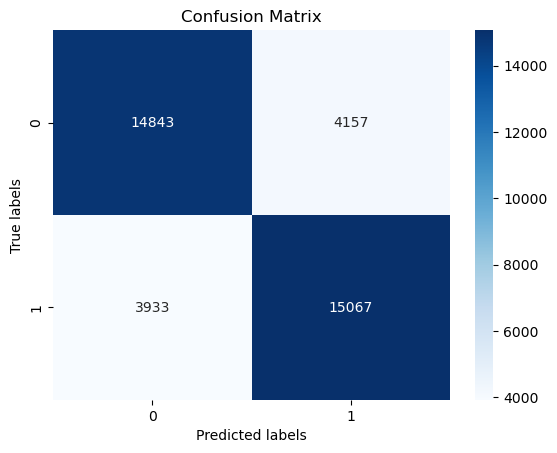

In [22]:
# confusion matrix heatmap with seaborn
cm = confusion_matrix(true_labels, predicted_labels)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")

In [23]:
# precision: out of all the predicted positive classes, how many were actually positive
precision = np.sum(cm[1, 1]) / (np.sum(cm[1, 1]) + np.sum(cm[0, 1]))
print("\nPrecision: {:.2f}".format(precision))

# recall: out of all the actual positive classes, how many were predicted positive
recall = np.sum(cm[1, 1]) / (np.sum(cm[1, 1]) + np.sum(cm[1, 0]))
print("Recall: {:.2f}".format(recall))


Precision: 0.78
Recall: 0.79


From the above results we can conclude that our model is very well balanced in its predictions.

Overall, these initial results are quite promising. As we explained throughout the process, there are still a few hyperparameters that can be adjusted to improve the model's performance. Additionally, we shall explore ways of adding more context to our embeddings by finding a way to include word order.

### Further considerations

One of our objectives was to create word embeddings specific to sentiment analysis. Arguably, we can use the word embeddings learned in this process for sentiment analysis on similar datasets. Let's see a couple of embeddings examples to see if we can extract any insights from them:

In [24]:
# add embeddings to vocab
embeddings = model.embedding.weight.detach().cpu().numpy()
word_to_embedding = {word: embeddings[i] for word, i in vocab.get_stoi().items()}

In [28]:
def compare_embeddings(word1, word2):
    """
    Compare the embeddings of two words
    """
    if word1 not in word_to_embedding:
        word1 = "<unk>"
    if word2 not in word_to_embedding:
        word2 = "<unk>"

    print(
        f"Comparing {word1} and {word2}: {np.dot(word_to_embedding[word1], word_to_embedding[word2]):.2f}"
    )


compare_embeddings("fantastic", "terrible")
compare_embeddings("fantastic", "phenomenal")
compare_embeddings("fantastic", "great")
compare_embeddings("fantastic", "bad")
compare_embeddings("terrible", "bad")
compare_embeddings("fantastic", "dog")

Comparing fantastic and terrible: -202.92
Comparing fantastic and phenomenal: 124.73
Comparing fantastic and great: 82.63
Comparing fantastic and bad: -49.91
Comparing terrible and bad: 83.04
Comparing fantastic and dog: 0.39


From the above results we can gather some intuition into some of the relationships that were learned: We would expect that words that convey similar sentiment would have similar embeddings (and therefore a positive dot product). Words that convey sentiment in the same direction but with different intensity would be positive but with a lower dot product. Words that convey sentiment in the opposite direction would have a negative dot product. Finally, comparing a word with sentimental value to a word with no sentimental value should result in a dot product close to zero.